In [22]:
import os
import pickle
from copy import deepcopy
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import gymnasium as gym

import gym_env
from utils import test_agent, get_full_maze_values, update_terminal_reward, get_transition_matrix, create_mapping_nb, get_map
from utils_render import render_V, render_maze, record_trajectory
from models import LinearRL

In [2]:
def new_goal(agent, T, loc):
    """
    New Environment is the same as the old one, with the inclusion of a new goal state that we want to use the old DR to
    plan towards
    
    Args:
    agent (LinearRL class): The LinearRL agent 
    T (array): The transition matrix of the new environment
    loc (tuple): Location of the new goal state
    """
    D0 = agent.gamma * agent.DR
    L0 = np.diag(np.exp(-agent.r)) - agent.T
    # D0 = np.linalg.inv(L0)
    L = np.diag(np.exp(-agent.r)) - T

    idx = [agent.mapping[loc], agent.mapping[(9,9)]]

    d = L[idx, :] - L0[idx, :]
    m0 = D0[:,idx]

    c = np.zeros_like(m0)
    c[idx[0], 0] = 1
    c[idx[1], 1] = 1

    a = np.linalg.inv(np.eye(len(idx)) + d @ D0 @ c)

    D = D0 - (D0 @ c @ a @ d @ D0)

    # # Set agent's DR to new DR
    agent.DR = D

    # Update terminals
    agent.terminals = np.diag(T) == 1
    # Update P
    agent.P = T[~agent.terminals][:,agent.terminals]
    # Update reward
    agent.r = np.full(len(T), -1)     # our reward at each non-terminal state to be -1
    agent.r[agent.terminals] = 20     # reward at terminal state is 20
    agent.expr = np.exp(agent.r[agent.terminals] / agent._lambda)

def transfer_terminal(env):
    return

def pretty_print_values(agent):
    values = get_full_maze_values(agent)
    max_width = max(len("{:.2f}".format(value)) for row in values for value in row if not np.isinf(value))

    # Print the matrix
    for row in values:
        for value in row:
            if np.isinf(value):
                print("{:>{}}".format("-inf", max_width), end=" ")
            else:
                print("{:>{}}".format("{:.2f}".format(value), max_width), end=" ")
        print()

def record_trajectory(agent, traj, save_path=None):
    fig, ax = plt.subplots()

    m = get_map(agent)
    
    # Display maze
    ax.imshow(m, origin='upper', cmap='gray_r')

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(m), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(m), 1), minor=True)

    ax.grid(which="minor", color='black', linewidth=2, alpha=0.5)
    # Display agent
    agent_loc = patches.Circle((agent.start_loc[1],agent.start_loc[0]), radius=0.4, fill=True, color='blue', alpha=0.7)
    ax.add_patch(agent_loc)

    # Display Reward
    for i, target_loc in enumerate(agent.target_locs):
        # reward = patches.Circle((target_loc[1], target_loc[0]), radius=0.4, fill=True, color='green')
        reward = patches.Rectangle((target_loc[1] - 0.5, target_loc[0] - 0.5), 1.0, 1.0, fill=True, color='green', alpha=0.7)
        ax.text(target_loc[1], target_loc[0], f'r{i+1}', color='white', fontsize=10, ha='center', va='center')
        ax.add_patch(reward)
    
    # loop through trajectory and add arrows
    for i in range(1, len(traj)):  # Start from the second position
        # Calculate the direction of movement
        diff = traj[i] - traj[i-1]
        # Start the arrow slightly behind the current position
        start_point = traj[i-1] - 0.2 * diff
        arrow = patches.FancyArrow(x=start_point[1], y=start_point[0], dx=0.5*diff[1], dy=0.5*diff[0], width=0.06, length_includes_head=True, color="red")
        ax.add_patch(arrow)

    # Hide tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Hide tick marks
    ax.tick_params(which='both', size=0)

    # Save the image
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

In [3]:
# Set the random seed for NumPy
seed = 26
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [4]:
# Hyperparams
alpha = 0.25
beta = 1.5
_lambda = 1.0

In [5]:
# envs = ["simple-15x15", "tolman-10x10-latent"]
# envs_new = ["simple-15x15-new-goal", "tolman-10x10-latent-new-goal"]
# new_locs = [(3,5), (9,9)]

no_goal_env = "maze-10x10-G0"
envs = ["maze-10x10-G1", "maze-10x10-G2", "maze-10x10-G3"]

# no_goal_env = "maze-15x15-G0"
# envs = ["maze-15x15-G1"]

In [6]:
# Transition matrix with no goal
env = gym.make(no_goal_env)
maze = env.unwrapped.maze
# Get the transition matrix of the new environment
mapping = create_mapping_nb(env.unwrapped.maze, env.unwrapped.get_walls())
T_no_goal = get_transition_matrix(env, mapping)

In [7]:
agent = LinearRL(env_name=envs[0], _lambda=_lambda, beta=beta, alpha=alpha, num_steps=30000, policy="softmax", imp_samp=True)
# update_terminal_reward(agent, loc=0, r=-1)

In [8]:
D_inv = agent.get_D_inv()
# agent.DR = D_inv
# agent.update_V()

In [9]:
agent.learn()

In [10]:
D0_inv = np.linalg.inv(np.diag(np.exp(-agent.r)) - agent.T)
print(np.max(np.abs(D0_inv - agent.gamma * D_inv)))
print(np.max(np.abs(D0_inv - agent.gamma * agent.DR)))

1.1102230246251565e-16
0.57062312985241


In [11]:
# pretty_print_values(agent)

In [19]:
# traj = test_agent(agent)

In [20]:
# record_trajectory(agent=agent, traj=traj, save_path=None)

### Find optimal path by reusing Original DR

In [15]:
num_steps_DR_TD = {}

# Get an iterator for the dictionary
dict_iter = iter(mapping.items())
next(dict_iter)

# Iterate through the remaining key-value pairs
for loc, idx in islice(dict_iter, len(mapping) - 2):
    # New agent for testing (copy of original agent)
    new_agent = deepcopy(agent)

    # Construct a new transition matrix and new environment
    T_new = np.copy(T_no_goal)
    T_new[idx, idx] = 1
    env_new = env
    env_new.unwrapped.target_locs = [np.array((loc[0], loc[1]))]

    # Use Woodbury update to plan towards new goal
    new_goal(new_agent, T_new, loc)

    new_agent.update_V()
    new_agent.env = env_new
    traj = test_agent(new_agent)
    print(f"Goal at location: {loc} | Number of steps: {len(traj)}")
    num_steps_DR_TD[loc] = len(traj)

Goal at location: (0, 1) | Number of steps: 1
Goal at location: (0, 2) | Number of steps: 2
Goal at location: (0, 4) | Number of steps: 8
Goal at location: (0, 7) | Number of steps: 21
Goal at location: (0, 8) | Number of steps: 20
Goal at location: (0, 9) | Number of steps: 21
Goal at location: (1, 0) | Number of steps: 1
Goal at location: (1, 1) | Number of steps: 2
Goal at location: (1, 2) | Number of steps: 3
Goal at location: (1, 4) | Number of steps: 7
Goal at location: (1, 6) | Number of steps: 21
Goal at location: (1, 7) | Number of steps: 20
Goal at location: (1, 8) | Number of steps: 19
Goal at location: (1, 9) | Number of steps: 20
Goal at location: (2, 2) | Number of steps: 4
Goal at location: (2, 3) | Number of steps: 5
Goal at location: (2, 4) | Number of steps: 6
Goal at location: (2, 7) | Number of steps: 19
Goal at location: (2, 8) | Number of steps: 18
Goal at location: (2, 9) | Number of steps: 19
Goal at location: (3, 0) | Number of steps: 7
Goal at location: (3, 1)

In [23]:
# Save the dictionary to a file
with open('../out/num_steps_DR_TD.pkl', 'wb') as file:
    pickle.dump(num_steps_DR_TD, file)

### BFS Approach for finding the optimal path

In [39]:
from collections import deque

def find_optimal_path(maze, start, end):
    visited = set()
    queue = deque([(tuple(start), [start])])

    while queue:
        current, path = queue.popleft()
        if np.array_equal(current, end):
            return path

        if current in visited:
            continue

        visited.add(current)

        for successor in env.unwrapped.get_successor_states(current):
            neighbor = successor[0]
            if tuple(neighbor) not in visited:
                queue.append((tuple(neighbor), path + [neighbor]))

    return None

### Find optimal path via exhaustive search

In [40]:
for successor in agent.env.unwrapped.get_successor_states(agent.start_loc):
    print(successor[0])

[1 0]
[0 1]


In [45]:
num_steps_exhaustive = {}

# Get an iterator for the dictionary
dict_iter = iter(mapping.items())
next(dict_iter)

# Original starting location
start_loc = agent.start_loc

# Iterate through the remaining key-value pairs
for loc, idx in islice(dict_iter, len(mapping) - 2):
    # New end location
    target_loc = np.array((loc[0], loc[1]))

    # New agent for testing (copy of original agent)
    new_agent = deepcopy(agent)

    # Construct a new transition matrix and new environment
    T_new = np.copy(T_no_goal)
    T_new[idx, idx] = 1
    env_new = env
    env_new.unwrapped.target_locs = [target_loc]

    # Find the optimal path
    path = find_optimal_path(env_new, start=start_loc, end=target_loc)
    if path is not None:
        print(f"Goal at location: {loc} | Number of steps: {len(path)-1}")
        num_steps_exhaustive[loc] = len(path) - 1
    

Goal at location: (0, 1) | Number of steps: 1
Goal at location: (0, 2) | Number of steps: 2
Goal at location: (0, 4) | Number of steps: 8
Goal at location: (0, 7) | Number of steps: 21
Goal at location: (0, 8) | Number of steps: 20
Goal at location: (0, 9) | Number of steps: 21
Goal at location: (1, 0) | Number of steps: 1
Goal at location: (1, 1) | Number of steps: 2
Goal at location: (1, 2) | Number of steps: 3
Goal at location: (1, 4) | Number of steps: 7
Goal at location: (1, 6) | Number of steps: 21
Goal at location: (1, 7) | Number of steps: 20
Goal at location: (1, 8) | Number of steps: 19
Goal at location: (1, 9) | Number of steps: 20
Goal at location: (2, 2) | Number of steps: 4
Goal at location: (2, 3) | Number of steps: 5
Goal at location: (2, 4) | Number of steps: 6
Goal at location: (2, 7) | Number of steps: 19
Goal at location: (2, 8) | Number of steps: 18
Goal at location: (2, 9) | Number of steps: 19
Goal at location: (3, 0) | Number of steps: 7
Goal at location: (3, 1)

In [46]:
# Save the dictionary to a file
with open('../out/num_steps_exhaustive.pkl', 'wb') as file:
    pickle.dump(num_steps_exhaustive, file)

### Plot the paths against one another

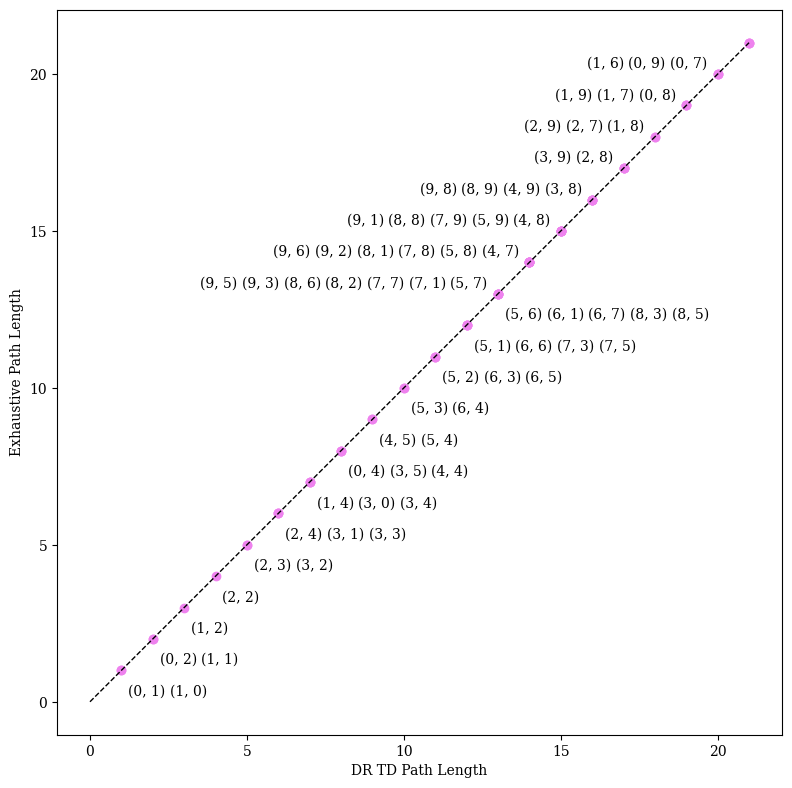

In [83]:
save_path = save_dir + 'complex_maze_path_length.png'

# Extract the path lengths and target locations from the dictionaries
DR_TD_lengths = list(num_steps_DR_TD.values())
exhaustive_lengths = list(num_steps_exhaustive.values())
target_locations = list(num_steps_DR_TD.keys())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Set the font to serif
plt.rcParams['font.family'] = 'serif'

# Plot the path lengths as scatter points with violet color
ax.scatter(DR_TD_lengths, exhaustive_lengths, color='violet')

# Add labels for points with length < 14
label_positions = {}
for i, location in enumerate(target_locations):
    x, y = DR_TD_lengths[i], exhaustive_lengths[i]
    if x < 14 and y < 14:
        if (x, y) not in label_positions:
            label_positions[(x, y)] = [(5, -10)]
        else:
            prev_x, prev_y = label_positions[(x, y)][-1]
            label_positions[(x, y)].append((prev_x + 30, prev_y))  # Increase spacing between labels

        xytext = label_positions[(x, y)][-1]
        ax.annotate(f"({location[0]}, {location[1]})", (x, y),
                    textcoords="offset points", xytext=xytext, ha='left', va='top')

# Add labels for points with length >= 14
label_offsets = {}
for i, location in enumerate(target_locations):
    x, y = DR_TD_lengths[i], exhaustive_lengths[i]
    if x >= 14 or y >= 14:
        if (x, y) not in label_offsets:
            label_offsets[(x, y)] = 0
        else:
            label_offsets[(x, y)] += 1

        offset = 30 * label_offsets[(x, y)]  # Adjust the horizontal offset based on the number of labels
        xytext = (-30 - offset, -10)  # Position labels slightly to the left of the y=x line
        ax.annotate(f"({location[0]}, {location[1]})", (x, y),
                    textcoords="offset points", xytext=xytext, ha='right', va='top')

# Set the labels and title for the plot
ax.set_xlabel('DR TD Path Length')
ax.set_ylabel('Exhaustive Path Length')

# Add a diagonal line representing equal path lengths
max_length = max(max(DR_TD_lengths), max(exhaustive_lengths))
ax.plot([0, max_length], [0, max_length], 'k--', linewidth=1)

# Set equal scales for both axes
ax.set_aspect('equal')

if save_path is not None:
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
D_new = replan_barrier(agent=agent_with_imp, T_new=T_new, delta_locs=delta_locs)